In [1]:
path = "fiscal_data_2020-10-11.csv"
l=[]
with open(path,'r',encoding='utf-8') as file:
    for line in file:
        l.append(line.strip())
        if len(l)>=100:
            break
print(l[0])
print(l[56])

e35d7164ee96e9aaf68b73c96fcb5bdc,{"receiptCode":3,"fiscalDocumentNumber":11278,"dateTime":"2020-10-11","shiftNumber":35,"requestNumber":48,"operationType":1,"totalSum":9215,"items":[{"name":"Продажа на сумму","price":9215,"quantity":1,"sum":9215}],"cashTotalSum":9215,"ecashTotalSum":0,"ndsNo":9215,"retailAddress":"652888, Кемеровская область, г. Междуреченск, ул. Октябрьская, д. 3А","taxationType":8},137f0b74c99ad372af7022794574d8e4
aea61cc5f3dcf7843090b1dfe6df705d,{"totalSum":20000,"requestNumber":16,"dateTime":"2020-10-11","shiftNumber":218,"operationType":1,"taxationType":32,"cashTotalSum":0,"ecashTotalSum":20000,"fiscalDocumentNumber":15262,"receiptCode":3,"addressToCheckFiscalSign":"","items":[{"name":"Капучино 400 мл (Молоко, сироп карамель)","price":20000,"quantity":1,"sum":20000}],"buyerAddress":"","senderAddress":"","ndsNo":20000},7cd7862b7b8e0147a16e987fa871b3e5


In [2]:
import dask.bag as db
import json
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar

file_path = "fiscal_data_2020-10-11.csv"

def process_data(line):
    try:
        start = line.index('{')
        end = line.rindex('}') + 1
        json_str = line[start:end]
        data = json.loads(json_str)

        items = data.get('items', [])
        if items:
            prices = [item.get('price', np.nan) for item in items]
            quantities = [item.get('quantity', np.nan) for item in items]
            sums = [item.get('sum', np.nan) for item in items]
            data['avg_item_price'] = sum(sums) / sum(quantities) if quantities and sum(quantities) > 0 else np.nan
            data['max_item_price'] = max(prices) if prices else np.nan
            data['min_item_price'] = min(prices) if prices else np.nan
            data['len_items'] = len(items)

        if 'items' in data:
            del data['items']

        return data
    except Exception as e:
        return {}

b = db.read_text(file_path).map(lambda x: x.strip())

limited_bag = b.take(5000000)

processed_bag = db.from_sequence(limited_bag).map(process_data)

pbar = ProgressBar()
pbar.register()

with pbar:
    result = processed_bag.compute(scheduler='threads')

result_df = pd.DataFrame(result)


[########################################] | 100% Completed | 64.65 s


In [3]:
result_df.isna().sum()

receiptCode              122162
fiscalDocumentNumber          0
dateTime                      0
shiftNumber                   0
requestNumber                 0
                         ...   
correctionBase          4999976
recipientName           4999896
ndsCalculated20         4999974
transferOperatorInn     4999996
recipientInn            4999975
Length: 86, dtype: int64

In [4]:
pd.set_option('display.max_columns', 10)
result_df

,receiptCode,fiscalDocumentNumber,dateTime,shiftNumber,requestNumber,...,correctionBase,recipientName,ndsCalculated20,transferOperatorInn,recipientInn
0,3.0,11278,2020-10-11,35,48,...,NaN,NaN,NaN,NaN,NaN
1,3.0,11279,2020-10-11,35,49,...,NaN,NaN,NaN,NaN,NaN
2,3.0,11280,2020-10-11,35,50,...,NaN,NaN,NaN,NaN,NaN
3,3.0,11281,2020-10-11,35,51,...,NaN,NaN,NaN,NaN,NaN
4,3.0,11282,2020-10-11,35,52,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4999995,3.0,86533,2020-10-11,847,19,...,NaN,NaN,NaN,NaN,NaN
4999996,3.0,17732,2020-10-11,737,5,...,NaN,NaN,NaN,NaN,NaN
4999997,3.0,17733,2020-10-11,737,6,...,NaN,NaN,NaN,NaN,NaN
4999998,3.0,17734,2020-10-11,737,7,...,NaN,NaN,NaN,NaN,NaN


In [5]:
na_counts = result_df.isna().sum()
na_percent = 100 * na_counts / len(result_df)
print(na_percent.to_dict())

{'receiptCode': 2.44324, 'fiscalDocumentNumber': 0.0, 'dateTime': 0.0, 'shiftNumber': 0.0, 'requestNumber': 0.0, 'operationType': 0.0, 'totalSum': 0.04036, 'cashTotalSum': 0.0773, 'ecashTotalSum': 0.14966, 'ndsNo': 56.5164, 'retailAddress': 94.26104, 'taxationType': 4e-05, 'avg_item_price': 0.08228, 'max_item_price': 0.08188, 'min_item_price': 0.08188, 'len_items': 0.08174, 'addressToCheckFiscalSign': 84.822, 'buyerAddress': 82.70834, 'senderAddress': 77.34174, 'nds18': 63.96882, 'nds10': 71.97614, 'fiscalDocumentFormatVer': 84.42218, 'prepaidSum': 84.38086, 'creditSum': 84.38088, 'provisionSum': 84.38088, 'authorityUri': 96.58062, 'internetSign': 98.08782, 'message': 95.51542, 'stornoItems': 95.51504, 'modifiers': 95.51468, 'ndsCalculated18': 94.25108, 'nds0': 94.88952, 'nds20': 93.218, 'protocolVersion': 86.5307, 'counterSubmissionSum': 86.52834, 'postpaymentSum': 86.52818, 'prepaymentSum': 86.52834, 'fnsUrl': 91.74654, 'code': 97.65426, 'operatorPhoneToTransfer': 97.53496, 'operator

In [6]:
d={}
for key,value in na_percent.to_dict().items():
    if value<=50:
        d[key]=value
print(d)

{'receiptCode': 2.44324, 'fiscalDocumentNumber': 0.0, 'dateTime': 0.0, 'shiftNumber': 0.0, 'requestNumber': 0.0, 'operationType': 0.0, 'totalSum': 0.04036, 'cashTotalSum': 0.0773, 'ecashTotalSum': 0.14966, 'taxationType': 4e-05, 'avg_item_price': 0.08228, 'max_item_price': 0.08188, 'min_item_price': 0.08188, 'len_items': 0.08174}


In [7]:
columns_to_keep = ['receiptCode', 'fiscalDocumentNumber', 'shiftNumber', 'requestNumber', 'operationType', 'totalSum', 'cashTotalSum', 'ecashTotalSum', 'len_items', 'avg_item_price', 'min_item_price', 'max_item_price', 'taxationType']
df=result_df[columns_to_keep].dropna()
df

,receiptCode,fiscalDocumentNumber,shiftNumber,requestNumber,operationType,...,len_items,avg_item_price,min_item_price,max_item_price,taxationType
0,3.0,11278,35,48,1,...,1.0,9215.0,9215.0,9215.0,8.0
1,3.0,11279,35,49,1,...,1.0,39746.0,39746.0,39746.0,8.0
2,3.0,11280,35,50,1,...,1.0,6050.0,6050.0,6050.0,8.0
3,3.0,11281,35,51,1,...,1.0,5000.0,5000.0,5000.0,8.0
4,3.0,11282,35,52,1,...,1.0,3400.0,3400.0,3400.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
4999995,3.0,86533,847,19,1,...,1.0,8260.0,8260.0,8260.0,8.0
4999996,3.0,17732,737,5,1,...,3.0,45000.0,6000.0,99000.0,8.0
4999997,3.0,17733,737,6,1,...,1.0,52900.0,52900.0,52900.0,8.0
4999998,3.0,17734,737,7,1,...,1.0,7500.0,7500.0,7500.0,8.0


In [8]:
pd.value_counts(df['taxationType'])

taxationType
1.0      2509863
8.0      1352408
0.0       429217
4.0       345918
2.0       121795
32.0       83998
16.0       17156
64.0          29
128.0         16
34.0           2
Name: count, dtype: int64

In [9]:
values_to_remove = [34.0, 64.0, 128.0]
mask = ~df['taxationType'].isin(values_to_remove)
filtered_df = df[mask]
filtered_df

,receiptCode,fiscalDocumentNumber,shiftNumber,requestNumber,operationType,...,len_items,avg_item_price,min_item_price,max_item_price,taxationType
0,3.0,11278,35,48,1,...,1.0,9215.0,9215.0,9215.0,8.0
1,3.0,11279,35,49,1,...,1.0,39746.0,39746.0,39746.0,8.0
2,3.0,11280,35,50,1,...,1.0,6050.0,6050.0,6050.0,8.0
3,3.0,11281,35,51,1,...,1.0,5000.0,5000.0,5000.0,8.0
4,3.0,11282,35,52,1,...,1.0,3400.0,3400.0,3400.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
4999995,3.0,86533,847,19,1,...,1.0,8260.0,8260.0,8260.0,8.0
4999996,3.0,17732,737,5,1,...,3.0,45000.0,6000.0,99000.0,8.0
4999997,3.0,17733,737,6,1,...,1.0,52900.0,52900.0,52900.0,8.0
4999998,3.0,17734,737,7,1,...,1.0,7500.0,7500.0,7500.0,8.0


In [10]:
y=filtered_df['taxationType']
X=filtered_df.drop(columns=['taxationType'])

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y_l_encoded=label_encoder.fit_transform(y)
d_classes={i:label_encoder.classes_[i] for i in range(len(label_encoder.classes_))}
print(d_classes)

{0: 0.0, 1: 1.0, 2: 2.0, 3: 4.0, 4: 8.0, 5: 16.0, 6: 32.0}


In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

X_train_label,X_test_label,y_train_label,y_test_label=train_test_split(X,y_l_encoded,test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train_label)
X_train_label = scaler.transform(X_train_label)
X_test_label = scaler.transform(X_test_label)

one_hot_encoder=OneHotEncoder(sparse_output=False)
y_ohe_encoded=one_hot_encoder.fit_transform(y_l_encoded.reshape(-1,1))
X_train_ohe,X_test_ohe,y_train_ohe,y_test_ohe=train_test_split(X,y_ohe_encoded,test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train_ohe)
X_train_ohe = scaler.transform(X_train_ohe)
X_test_ohe = scaler.transform(X_test_ohe)

In [19]:
def model_eval(model,X_train,y_train,X_test,y_test):
    test_model=model
    start_time = time.time()
    test_model.fit(X_train,y_train)
    elapsed_time = time.time() - start_time 
    accuracy = test_model.score(X_test, y_test)
    return accuracy,elapsed_time

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import time 
to_check = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
}
df = pd.DataFrame()
acc = []
t = []
names = []
for name, model in to_check.items():
    accuracy, elapsed_time = model_eval(model, X_train_label, y_train_label, X_test_label, y_test_label)
    acc.append(accuracy)
    t.append(elapsed_time)
    names.append(name)

df['Model'] = names
df['Accuracy'] = acc
df['Time'] = t
df

,Model,Accuracy,Time
0,LogisticRegression,0.635563,88.767151
1,DecisionTreeClassifier,0.691043,46.150835
2,KNeighborsClassifier,0.666104,10.988138


In [21]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_label, label=y_train_label)
dtest = xgb.DMatrix(X_test_label, label=y_test_label)
params = {
    'objective': 'multi:softprob',
    'num_class': 7,
    'max_depth': 13,
    'n_jobs': 9,
    'eval_metric': ['mlogloss', 'merror']
}
evals_result = {}
start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=250, evals=[(dtrain, 'train'), (dtest, 'test')],
                evals_result=evals_result, verbose_eval=True)
elapsed_time = time.time() - start_time
train_accuracy = [1 - x for x in evals_result['train']['merror']]
test_accuracy = [1 - x for x in evals_result['test']['merror']]

[0]	train-mlogloss:1.49567	train-merror:0.32314	test-mlogloss:1.49967	test-merror:0.32691
[1]	train-mlogloss:1.28930	train-merror:0.31800	test-mlogloss:1.29652	test-merror:0.32199
[2]	train-mlogloss:1.15785	train-merror:0.31538	test-mlogloss:1.16778	test-merror:0.31985
[3]	train-mlogloss:1.06695	train-merror:0.31332	test-mlogloss:1.07940	test-merror:0.31813
[4]	train-mlogloss:1.00059	train-merror:0.31145	test-mlogloss:1.01542	test-merror:0.31662
[5]	train-mlogloss:0.95114	train-merror:0.30968	test-mlogloss:0.96818	test-merror:0.31508
[6]	train-mlogloss:0.91252	train-merror:0.30730	test-mlogloss:0.93165	test-merror:0.31301
[7]	train-mlogloss:0.88209	train-merror:0.30535	test-mlogloss:0.90316	test-merror:0.31179
[8]	train-mlogloss:0.85839	train-merror:0.30378	test-mlogloss:0.88128	test-merror:0.31034
[9]	train-mlogloss:0.83927	train-merror:0.30208	test-mlogloss:0.86385	test-merror:0.30901
[10]	train-mlogloss:0.82172	train-merror:0.29972	test-mlogloss:0.84801	test-merror:0.30701
[11]	trai

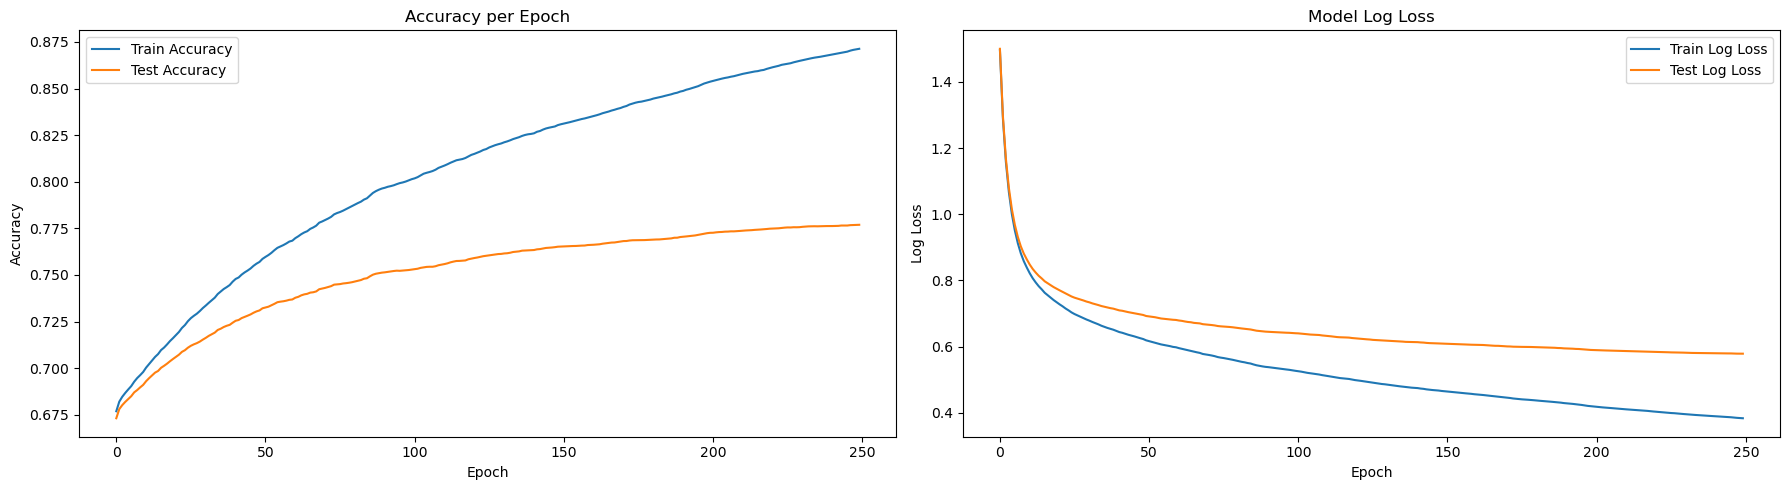

Затраченное время 336.79, Итоговая точность 77.69%


In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(test_accuracy, label='Test Accuracy')
ax[0].set_title('Accuracy per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(evals_result['train']['mlogloss'], label='Train Log Loss')
ax[1].plot(evals_result['test']['mlogloss'], label='Test Log Loss')
ax[1].set_title('Model Log Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Log Loss')
ax[1].legend()

plt.tight_layout()
plt.show()
print(f'Затраченное время {elapsed_time:.2f}, Итоговая точность {test_accuracy[-1]*100:.2f}%')


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu',input_shape=(12,)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 857223 (3.27 MB)
Trainable params: 8572

In [26]:
start_time = time.time()
history=model.fit(X_train_ohe,y_train_ohe,validation_data=(X_test_ohe, y_test_ohe),batch_size=256,epochs=4)
elapsed_time = time.time() - start_time

Epoch 1/4


15189/15189 [==============================] - 72s 5ms/step - loss: 0.9538 - accuracy: 0.6473 - val_loss: 0.9319 - val_accuracy: 0.6511
Epoch 2/4
15189/15189 [==============================] - 72s 5ms/step - loss: 0.9281 - accuracy: 0.6529 - val_loss: 0.9213 - val_accuracy: 0.6548
Epoch 3/4
15189/15189 [==============================] - 71s 5ms/step - loss: 0.9180 - accuracy: 0.6558 - val_loss: 0.9094 - val_accuracy: 0.6577
Epoch 4/4
15189/15189 [==============================] - 68s 4ms/step - loss: 0.9109 - accuracy: 0.6579 - val_loss: 0.9032 - val_accuracy: 0.6599


In [27]:
print(f"Затраченное время {elapsed_time:.2f}, Итоговая точность {history.history['val_accuracy'][-1]*100:.2f}%")

Затраченное время 283.10, Итоговая точность 65.99%


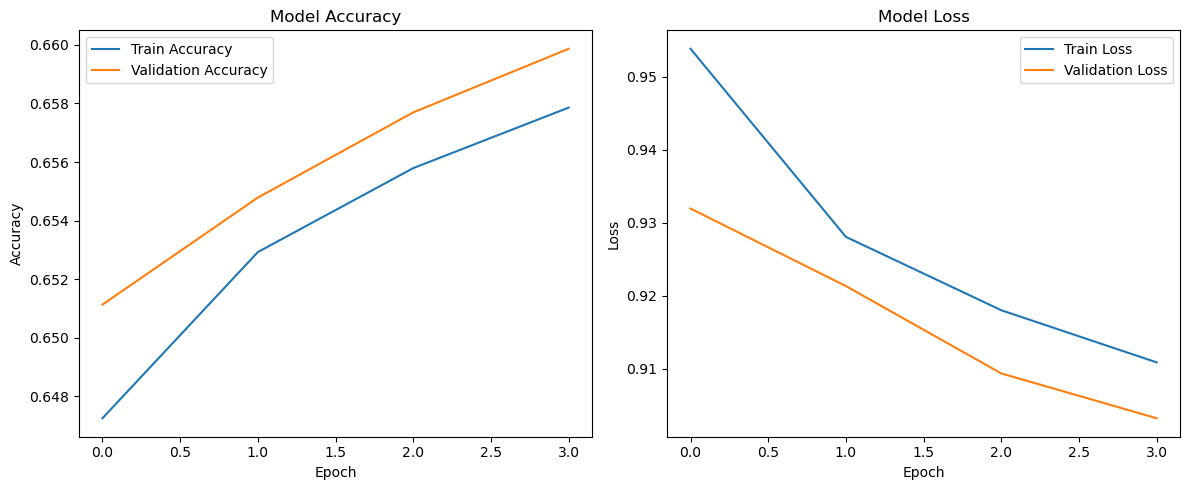

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
import dask.bag as db
import json
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar

file_path = "fiscal_data_2020-10-11.csv"

def process_data(line, columns_to_keep):
    try:
        start = line.index('{')
        end = line.rindex('}') + 1
        json_str = line[start:end]
        data = json.loads(json_str)
        filtered_data = {key: data.get(key, np.nan) for key in columns_to_keep}

        items = data.get('items', [])
        if items:
            prices = [item.get('price', np.nan) for item in items]
            quantities = [item.get('quantity', np.nan) for item in items]
            sums = [item.get('sum', np.nan) for item in items]

            filtered_data['avg_item_price'] = sum(sums) / sum(quantities) if quantities and sum(quantities) > 0 else np.nan
            filtered_data['max_item_price'] = max(prices) if prices else np.nan
            filtered_data['min_item_price'] = min(prices) if prices else np.nan
            filtered_data['len_items'] = len(items)
        return filtered_data
    except Exception as e:
        return {key: np.nan for key in columns_to_keep + ['avg_item_price', 'max_item_price', 'min_item_price', 'len_items']}

columns_to_keep = ['receiptCode', 'fiscalDocumentNumber', 'shiftNumber', 'requestNumber', 'operationType', 'totalSum', 'cashTotalSum', 'ecashTotalSum', 'len_items', 'avg_item_price', 'min_item_price', 'max_item_price', 'taxationType']

b = db.read_text(file_path).map(lambda x: x.strip())

processed_bag = b.map(lambda x: process_data(x, columns_to_keep))


pbar = ProgressBar()
pbar.register()

with pbar:
    result = processed_bag.compute(scheduler='threads')

df = pd.DataFrame(result)

[########################################] | 100% Completed | 419.91 s


In [30]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
df

,receiptCode,fiscalDocumentNumber,shiftNumber,requestNumber,operationType,...,len_items,avg_item_price,min_item_price,max_item_price,taxationType
0,3.0,11278,35,48.0,1,...,1.0,9215.000000,9215.0,9215.0,8.0
1,3.0,11279,35,49.0,1,...,1.0,39746.000000,39746.0,39746.0,8.0
2,3.0,11280,35,50.0,1,...,1.0,6050.000000,6050.0,6050.0,8.0
3,3.0,11281,35,51.0,1,...,1.0,5000.000000,5000.0,5000.0,8.0
4,3.0,11282,35,52.0,1,...,1.0,3400.000000,3400.0,3400.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
38012677,3.0,111,3,8.0,1,...,2.0,55000.000000,55000.0,55000.0,1.0
38012678,3.0,112,3,9.0,1,...,2.0,45000.000000,45000.0,45000.0,1.0
38012679,3.0,639,10,5.0,1,...,2.0,4548.555834,4548.0,4572.0,1.0
38012680,3.0,640,10,6.0,1,...,3.0,6233.333333,3900.0,9900.0,4.0


In [31]:
df=df.dropna()

In [32]:
values_to_remove = [128.0, 216.0, 34.0, 12.0, 10.0, -128.0, 120.0]
mask = ~df['taxationType'].isin(values_to_remove)

filtered_df = df[mask]

In [33]:
X=filtered_df.drop(columns=['taxationType'])
y=filtered_df['taxationType']

label_encoder = LabelEncoder()
y_transformed = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'multi:softprob',
    'num_class': 8,
    'max_depth': 13,
    'n_jobs': -1,
    'eval_metric': ['mlogloss', 'merror']
}
evals_result = {}
start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=250, evals=[(dtrain, 'train'), (dtest, 'test')],
                evals_result=evals_result, verbose_eval=True)
elapsed_time = time.time() - start_time
train_accuracy = [1 - x for x in evals_result['train']['merror']]
test_accuracy = [1 - x for x in evals_result['test']['merror']]

[0]	train-mlogloss:1.52413	train-merror:0.30508	test-mlogloss:1.52489	test-merror:0.30565
[1]	train-mlogloss:1.30035	train-merror:0.30120	test-mlogloss:1.30175	test-merror:0.30186
[2]	train-mlogloss:1.15894	train-merror:0.29914	test-mlogloss:1.16092	test-merror:0.29988
[3]	train-mlogloss:1.06119	train-merror:0.29712	test-mlogloss:1.06367	test-merror:0.29797
[4]	train-mlogloss:0.99082	train-merror:0.29544	test-mlogloss:0.99376	test-merror:0.29629
[5]	train-mlogloss:0.93905	train-merror:0.29409	test-mlogloss:0.94243	test-merror:0.29500
[6]	train-mlogloss:0.89974	train-merror:0.29251	test-mlogloss:0.90350	test-merror:0.29346
[7]	train-mlogloss:0.86966	train-merror:0.29121	test-mlogloss:0.87382	test-merror:0.29228
[8]	train-mlogloss:0.84602	train-merror:0.29006	test-mlogloss:0.85058	test-merror:0.29119
[9]	train-mlogloss:0.82682	train-merror:0.28882	test-mlogloss:0.83178	test-merror:0.29004
[10]	train-mlogloss:0.81097	train-merror:0.28757	test-mlogloss:0.81632	test-merror:0.28883
[11]	trai

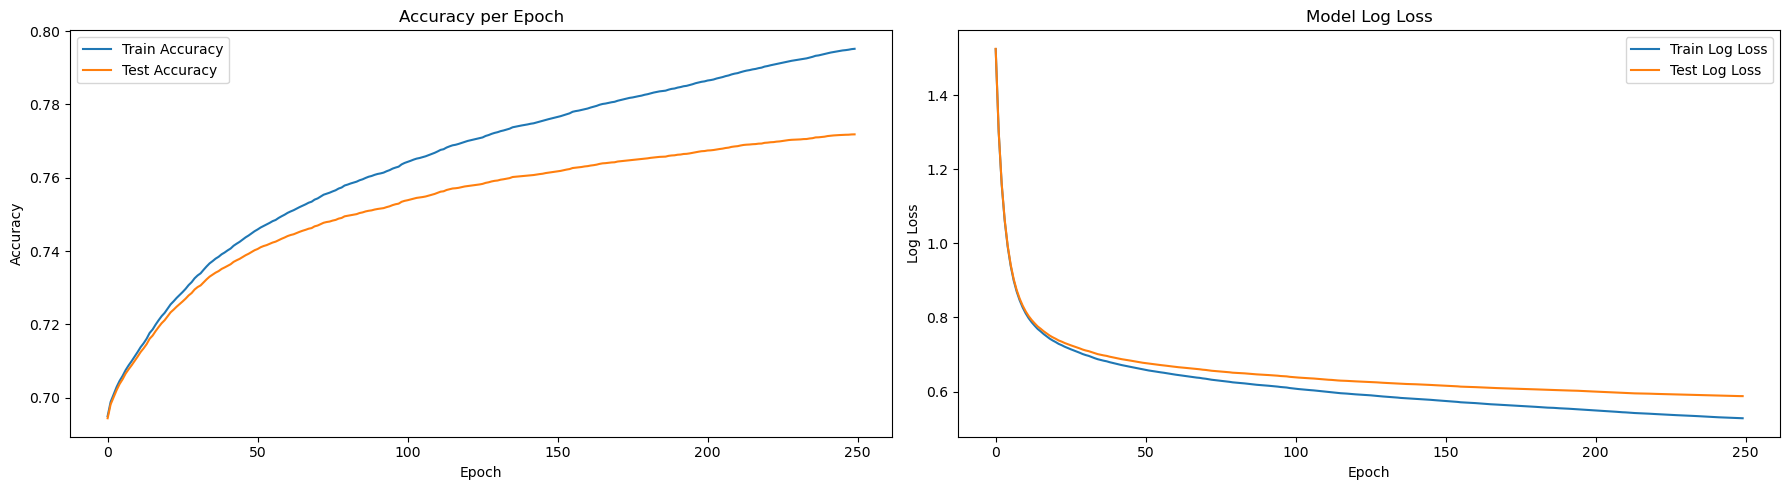

Затраченное время 4279.82, Итоговая точность 77.18%


In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(test_accuracy, label='Test Accuracy')
ax[0].set_title('Accuracy per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(evals_result['train']['mlogloss'], label='Train Log Loss')
ax[1].plot(evals_result['test']['mlogloss'], label='Test Log Loss')
ax[1].set_title('Model Log Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Log Loss')
ax[1].legend()

plt.tight_layout()
plt.show()
print(f'Затраченное время {elapsed_time:.2f}, Итоговая точность {test_accuracy[-1]*100:.2f}%')